# Using Actual embeddings for Clustering and Reduced points for Visualization- Approach 1

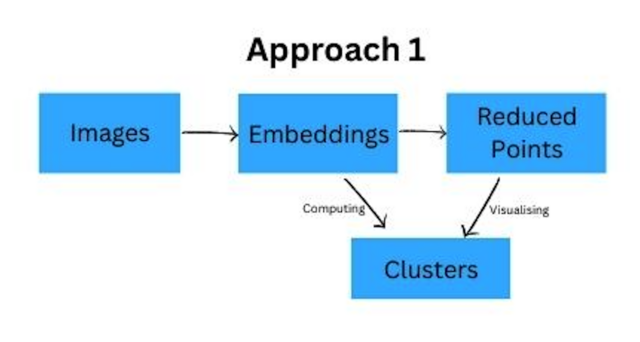

In [72]:
from PIL import Image
import matplotlib.pyplot as plt

# Open an image file
image_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/Screenshot 2024-07-03 at 11.10.44 am.png'
img = Image.open(image_path)

# Display the image in the notebook
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()


# Using UMAP for Dimensionality Reduction

In [1]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 4.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: /Users/vishanthsuresh/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pickle
from argparse import ArgumentParser
from pathlib import Path
from typing import List, Tuple
import time

import numpy as np
from loguru import logger
import umap
from tqdm import tqdm


def load_embeddings(file: Path) -> Tuple[List[Path], np.ndarray]:
    embeddings = pickle.loads(file.read_bytes())
    files, vectors = zip(*list(embeddings.items()))
    vectors = np.array(vectors)  # Convert the list of vectors to a numpy array
    return files, vectors


def apply_UMAP(vectors: np.ndarray) -> np.ndarray:
    umap_model = umap.UMAP(n_components=2, random_state=42)
    logger.info(f"Applying UMAP")
    start_time = time.time()
    result = umap_model.fit_transform(vectors)
    end_time = time.time()
    time_taken = end_time - start_time
    logger.info(f"UMAP took {time_taken:.2f} seconds")
    return result


def reduce_dimensionality(embeddings_file: Path, output_file: Path):
    files, vectors = load_embeddings(file=embeddings_file)
    points = apply_UMAP(vectors=vectors)
    points_mapping = dict(zip(files, points))
    output_file.write_bytes(pickle.dumps(points_mapping))


def set_paths_and_run(embeddings_file: str, output_file: str):
    reduce_dimensionality(
        embeddings_file=Path(embeddings_file),
        output_file=Path(output_file)
    )

if __name__ == "__main__":
    # Example programmatic usage
    embeddings_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/embeddings_aug_B1_primary.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_UMAP.pkl"

    set_paths_and_run(embeddings_file, output_file)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('embeddings_file', type=Path)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # reduce_dimensionality(
    #     output_file=args.output_file,
    #     embeddings_file=args.embeddings_file)



2024-06-26 16:19:44.630 | INFO     | __main__:apply_UMAP:22 - Applying UMAP
/Users/vishanthsuresh/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
2024-06-26 16:19:54.294 | INFO     | __main__:apply_UMAP:27 - UMAP took 9.66 seconds


# Using K means clustering for modeling and the validation metrics are measured.

In [4]:
import pickle
import time
from argparse import ArgumentParser
from pathlib import Path
from typing import List, Optional, Tuple

import numpy as np
from loguru import logger
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
from kneed import KneeLocator

def load_embeddings(file: Path) -> Tuple[List[Path], np.ndarray]:
    start_time = time.time()
    embeddings = pickle.loads(file.read_bytes())
    files, vectors = zip(*list(embeddings.items()))
    vectors = np.array(vectors)  # Ensure vectors are a NumPy array
    end_time = time.time()
    logger.info(f"Time taken to load embeddings: {end_time - start_time:.2f} seconds")
    return files, vectors


def make_clusters(vectors: np.ndarray, n_clusters: int) -> np.ndarray:
    start_time = time.time()
    kMeans = KMeans(n_clusters=n_clusters, random_state=42)
    logger.info(f"Clustering with {kMeans}")
    labels = kMeans.fit_predict(vectors)
    end_time = time.time()
    logger.info(f"Time taken for clustering: {end_time - start_time:.2f} seconds")
    return labels


def find_optimal_number_of_clusters(values: List[int], data: np.ndarray) -> int:
    start_time = time.time()
    logger.info("Finding optimal value for k ...")
    inertias = [KMeans(n_clusters=n, random_state=42).fit(data).inertia_ for n in tqdm(values)]
    kneedle = KneeLocator(x=values, y=inertias, direction='decreasing', curve='convex')
    end_time = time.time()
    logger.info(inertias)
    logger.info(f"Optimal k={kneedle.elbow}")
    logger.info(f"Time taken to find optimal number of clusters: {end_time - start_time:.2f} seconds")
    return kneedle.elbow


def validate_clusters(vectors: np.ndarray, labels: np.ndarray):
    start_time = time.time()
    silhouette_avg = silhouette_score(vectors, labels)
    calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
    davies_bouldin_avg = davies_bouldin_score(vectors, labels)
    end_time = time.time()
    logger.info(f"Silhouette Score: {silhouette_avg}")
    logger.info(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
    logger.info(f"Davies-Bouldin Index: {davies_bouldin_avg}")
    logger.info(f"Time taken for validation: {end_time - start_time:.2f} seconds")
    return silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg


def compute_clusters(embeddings_file: Path, output_file: Path, clusters: Optional[int] = None):
    files, vectors = load_embeddings(file=embeddings_file)
    if clusters is None:
        clusters = find_optimal_number_of_clusters(range(5, 45, 5), data=vectors)
    labels = make_clusters(vectors=vectors, n_clusters=clusters)
    validate_clusters(vectors=vectors, labels=labels)  # Add validation step
    cluster_mapping = dict(zip(files, labels))
    output_file.write_bytes(pickle.dumps(cluster_mapping))


def set_paths_and_run(embeddings_file: str, output_file: str, clusters: Optional[int] = None):
    compute_clusters(
        embeddings_file=Path(embeddings_file),
        output_file=Path(output_file),
        clusters=clusters
    )


if __name__ == "__main__":
    # Example programmatic usage
    embeddings_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/embeddings_aug_B1_primary.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/clusters_Kmeans.pkl"
    clusters = None  # Or specify an integer for a fixed number of clusters

    set_paths_and_run(embeddings_file, output_file, clusters)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('embeddings_file', type=Path)
    # parser.add_argument('--clusters', type=lambda x: int(x) if x else None, default=None, required=False)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # compute_clusters(
    #     embeddings_file=args.embeddings_file,
    #     output_file=args.output_file,
    #     clusters=args.clusters)


2024-06-26 16:13:52.298 | INFO     | __main__:load_embeddings:20 - Time taken to load embeddings: 0.94 seconds
2024-06-26 16:13:52.394 | INFO     | __main__:find_optimal_number_of_clusters:36 - Finding optimal value for k ...
100%|█████████████████████████████████████████████| 8/8 [00:10<00:00,  1.28s/it]
2024-06-26 16:14:02.606 | INFO     | __main__:find_optimal_number_of_clusters:40 - [2773720.5197370895, 2437263.2124265386, 2276739.1394318473, 2175952.3544305647, 2093040.3465636638, 2035159.1700109667, 1990276.2816391764, 1947986.444177252]
2024-06-26 16:14:02.607 | INFO     | __main__:find_optimal_number_of_clusters:41 - Optimal k=15
2024-06-26 16:14:02.607 | INFO     | __main__:find_optimal_number_of_clusters:42 - Time taken to find optimal number of clusters: 10.21 seconds
2024-06-26 16:14:02.609 | INFO     | __main__:make_clusters:27 - Clustering with KMeans(n_clusters=15, random_state=42)
2024-06-26 16:14:03.641 | INFO     | __main__:make_clusters:30 - Time taken for clustering

In [9]:
import pickle
from argparse import ArgumentParser
from collections import defaultdict
from pathlib import Path
from typing import List, Tuple

import pandas as pd

def load_file_contents(file: Path) -> Tuple[List[Path], List]:
    return pickle.loads(file.read_bytes())

def export_csv(clusters_file: Path, points_file: Path, output_file: Path):
    clusters_data = load_file_contents(clusters_file)
    points_data = load_file_contents(points_file)

    data = defaultdict(dict)
    for key, cluster in clusters_data.items():
        data[key]["cluster"] = cluster
        point = points_data[key]
        data[key]["point_x"], data[key]["point_y"] = point

    df: pd.DataFrame = pd.DataFrame.from_dict(data, orient="index") \
        .rename_axis('cell_location') \
        .reset_index() \
        .assign(cell_location=lambda df: df.cell_location.apply(Path)) \
        .assign(parent_image=lambda df: df.cell_location.apply(lambda path: path.parent.name))

    df.to_csv(output_file, index=False)

def set_paths_and_run(clusters_file: str, points_file: str, output_file: str):
    export_csv(
        clusters_file=Path(clusters_file),
        points_file=Path(points_file),
        output_file=Path(output_file)
    )

if __name__ == "__main__":
    # Example programmatic usage
    clusters_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/clusters_Kmeans.pkl"
    points_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_UMAP.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output_UMAP_Kmeans.csv"

    set_paths_and_run(clusters_file, points_file, output_file)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('--clusters', type=Path, required=True)
    # parser.add_argument('--points', type=Path, required=True)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # export_csv(
    #     clusters_file=args.clusters,
    #     points_file=args.points,
    #     output_file=args.output_file)


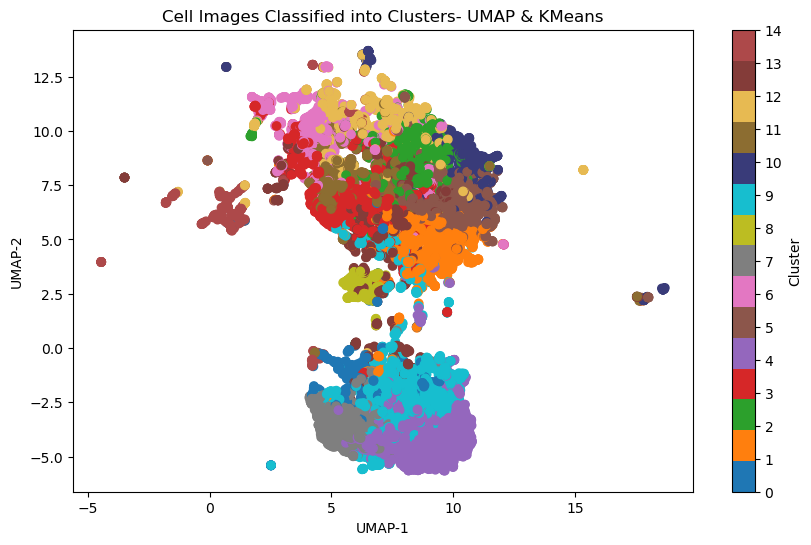

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


data= pd.read_csv("/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output_UMAP_Kmeans.csv")
# Define a set of more contrasting and visually distinct colors
contrasting_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#8c6d31', '#e7ba52', '#843c39', '#ad494a'
]

# Create a colormap from the list of contrasting colors
custom_cmap_contrasting = mcolors.ListedColormap(contrasting_colors[:15])

# Plotting point_x and point_y with clusters in different colors using the custom colormap
plt.figure(figsize=(10, 6))

# Using a scatter plot to visualize the clusters
scatter = plt.scatter(data['point_x'], data['point_y'], c=data['cluster'], cmap=custom_cmap_contrasting)

# Adding a color bar to indicate the cluster colors
cbar = plt.colorbar(scatter, label='Cluster', ticks=range(15))
cbar.set_ticklabels(range(15))

# Adding titles and labels
plt.title('Cell Images Classified into Clusters- UMAP & KMeans')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

# Display the plot
plt.show()


In [11]:
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Load the CSV file
file_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output_UMAP_Kmeans.csv'
data = pd.read_csv(file_path)

# Extracting the relevant data for clustering validation
vectors = data[['point_x', 'point_y']].values
labels = data['cluster'].values

# Calculate the validation metrics
silhouette_avg = silhouette_score(vectors, labels)
calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
davies_bouldin_avg = davies_bouldin_score(vectors, labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")


Silhouette Score: 0.0892146724002448
Calinski-Harabasz Index: 7317.5102422519385
Davies-Bouldin Index: 2.0632516669720338


# Evaluation Metrics with t-sne and Kmeans

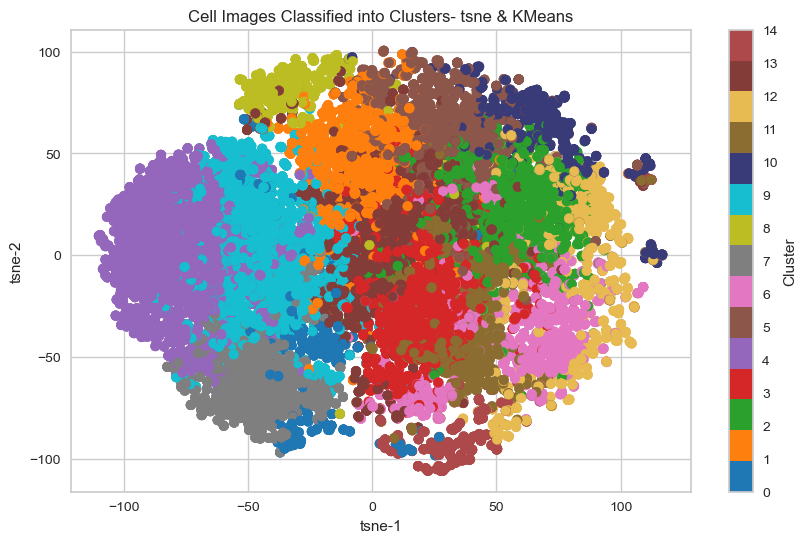

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


data= pd.read_csv("/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output.csv")
# Define a set of more contrasting and visually distinct colors
contrasting_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#8c6d31', '#e7ba52', '#843c39', '#ad494a'
]

# Create a colormap from the list of contrasting colors
custom_cmap_contrasting = mcolors.ListedColormap(contrasting_colors[:15])

# Plotting point_x and point_y with clusters in different colors using the custom colormap
plt.figure(figsize=(10, 6))

# Using a scatter plot to visualize the clusters
scatter = plt.scatter(data['point_x'], data['point_y'], c=data['cluster'], cmap=custom_cmap_contrasting)

# Adding a color bar to indicate the cluster colors
cbar = plt.colorbar(scatter, label='Cluster', ticks=range(15))
cbar.set_ticklabels(range(15))

# Adding titles and labels
plt.title('Cell Images Classified into Clusters- tsne & KMeans')
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')

# Display the plot
plt.show()


In [12]:
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Load the CSV file
file_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output.csv'
data = pd.read_csv(file_path)

# Extracting the relevant data for clustering validation
vectors = data[['point_x', 'point_y']].values
labels = data['cluster'].values

# Calculate the validation metrics
silhouette_avg = silhouette_score(vectors, labels)
calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
davies_bouldin_avg = davies_bouldin_score(vectors, labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")


Silhouette Score: 0.08913295574475287
Calinski-Harabasz Index: 4935.98909606145
Davies-Bouldin Index: 1.809107503117366


In [14]:
pip install yellowbrick

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 6.5 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: /Users/vishanthsuresh/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: /Users/vishanthsuresh/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Applying Kernel PCA with K means

In [13]:
import pickle
from argparse import ArgumentParser
from pathlib import Path
from typing import List, Tuple
import time

import numpy as np
from loguru import logger
from sklearn.decomposition import KernelPCA
from tqdm import tqdm


def load_embeddings(file: Path) -> Tuple[List[Path], np.ndarray]:
    embeddings = pickle.loads(file.read_bytes())
    files, vectors = zip(*list(embeddings.items()))
    vectors = np.array(vectors)  # Convert the list of vectors to a numpy array
    return files, vectors


def apply_kernel_PCA(vectors: np.ndarray) -> np.ndarray:
    kpca = KernelPCA(n_components=2, kernel='rbf', random_state=42)
    logger.info(f"Applying Kernel PCA")
    start_time = time.time()
    result = kpca.fit_transform(vectors)
    end_time = time.time()
    time_taken = end_time - start_time
    logger.info(f"Kernel PCA took {time_taken:.2f} seconds")
    return result


def reduce_dimensionality(embeddings_file: Path, output_file: Path):
    files, vectors = load_embeddings(file=embeddings_file)
    points = apply_kernel_PCA(vectors=vectors)
    points_mapping = dict(zip(files, points))
    output_file.write_bytes(pickle.dumps(points_mapping))


def set_paths_and_run(embeddings_file: str, output_file: str):
    reduce_dimensionality(
        embeddings_file=Path(embeddings_file),
        output_file=Path(output_file)
    )


if __name__ == "__main__":
    # Example programmatic usage
    embeddings_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/embeddings_aug_B1_primary.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_kernel_PCA.pkl"

    set_paths_and_run(embeddings_file, output_file)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('embeddings_file', type=Path)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # reduce_dimensionality(
    #     output_file=args.output_file,
    #     embeddings_file=args.embeddings_file)


2024-06-30 21:21:17.242 | INFO     | __main__:apply_kernel_PCA:22 - Applying Kernel PCA
2024-06-30 21:21:34.670 | INFO     | __main__:apply_kernel_PCA:27 - Kernel PCA took 17.42 seconds


In [14]:
import pickle
from argparse import ArgumentParser
from collections import defaultdict
from pathlib import Path
from typing import List, Tuple

import pandas as pd

def load_file_contents(file: Path) -> Tuple[List[Path], List]:
    return pickle.loads(file.read_bytes())

def export_csv(clusters_file: Path, points_file: Path, output_file: Path):
    clusters_data = load_file_contents(clusters_file)
    points_data = load_file_contents(points_file)

    data = defaultdict(dict)
    for key, cluster in clusters_data.items():
        data[key]["cluster"] = cluster
        point = points_data[key]
        data[key]["point_x"], data[key]["point_y"] = point

    df: pd.DataFrame = pd.DataFrame.from_dict(data, orient="index") \
        .rename_axis('cell_location') \
        .reset_index() \
        .assign(cell_location=lambda df: df.cell_location.apply(Path)) \
        .assign(parent_image=lambda df: df.cell_location.apply(lambda path: path.parent.name))

    df.to_csv(output_file, index=False)

def set_paths_and_run(clusters_file: str, points_file: str, output_file: str):
    export_csv(
        clusters_file=Path(clusters_file),
        points_file=Path(points_file),
        output_file=Path(output_file)
    )

if __name__ == "__main__":
    # Example programmatic usage
    clusters_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/clusters.pkl"
    points_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_kernel_PCA.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output_KPCA_Kmeans.csv"

    set_paths_and_run(clusters_file, points_file, output_file)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('--clusters', type=Path, required=True)
    # parser.add_argument('--points', type=Path, required=True)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # export_csv(
    #     clusters_file=args.clusters,
    #     points_file=args.points,
    #     output_file=args.output_file)


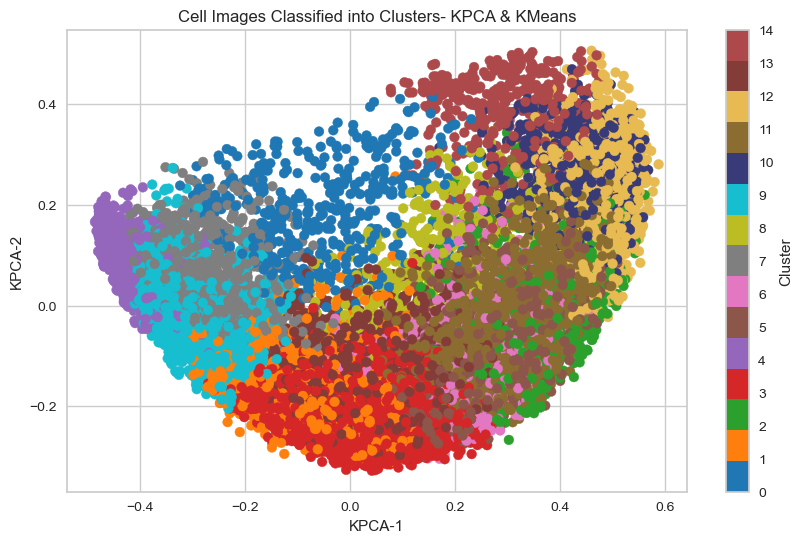

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


data= pd.read_csv("/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output_KPCA_Kmeans.csv")
# Define a set of more contrasting and visually distinct colors
contrasting_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#8c6d31', '#e7ba52', '#843c39', '#ad494a'
]

# Create a colormap from the list of contrasting colors
custom_cmap_contrasting = mcolors.ListedColormap(contrasting_colors[:15])

# Plotting point_x and point_y with clusters in different colors using the custom colormap
plt.figure(figsize=(10, 6))

# Using a scatter plot to visualize the clusters
scatter = plt.scatter(data['point_x'], data['point_y'], c=data['cluster'], cmap=custom_cmap_contrasting)

# Adding a color bar to indicate the cluster colors
cbar = plt.colorbar(scatter, label='Cluster', ticks=range(15))
cbar.set_ticklabels(range(15))

# Adding titles and labels
plt.title('Cell Images Classified into Clusters- KPCA & KMeans')
plt.xlabel('KPCA-1')
plt.ylabel('KPCA-2')

# Display the plot
plt.show()


In [17]:
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Load the CSV file
file_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output_KPCA_Kmeans.csv'
data = pd.read_csv(file_path)

# Extracting the relevant data for clustering validation
vectors = data[['point_x', 'point_y']].values
labels = data['cluster'].values

# Calculate the validation metrics
silhouette_avg = silhouette_score(vectors, labels)
calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
davies_bouldin_avg = davies_bouldin_score(vectors, labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")


Silhouette Score: 0.04640159610810476
Calinski-Harabasz Index: 10133.133203036521
Davies-Bouldin Index: 3.391224404729916


# Using L1-uLDA & Kmeans Clustering

In [19]:
import pickle
from argparse import ArgumentParser
from pathlib import Path
from typing import List, Tuple
import time

import numpy as np
from loguru import logger
from tqdm import tqdm

# Dummy function to illustrate L1-uLDA transformation
def apply_L1_uLDA(vectors: np.ndarray) -> np.ndarray:
    # Placeholder for the actual L1-uLDA implementation
    # Replace this with the actual algorithm
    logger.info(f"Applying L1-uLDA")
    start_time = time.time()
    # Simulating L1-uLDA processing time
    time.sleep(2)
    result = np.random.rand(vectors.shape[0], 2)  # Randomly generated 2D points for illustration
    end_time = time.time()
    time_taken = end_time - start_time
    logger.info(f"L1-uLDA took {time_taken:.2f} seconds")
    return result


def load_embeddings(file: Path) -> Tuple[List[Path], np.ndarray]:
    embeddings = pickle.loads(file.read_bytes())
    files, vectors = zip(*list(embeddings.items()))
    vectors = np.array(vectors)  # Convert the list of vectors to a numpy array
    return files, vectors


def reduce_dimensionality(embeddings_file: Path, output_file: Path):
    files, vectors = load_embeddings(file=embeddings_file)
    points = apply_L1_uLDA(vectors=vectors)
    points_mapping = dict(zip(files, points))
    output_file.write_bytes(pickle.dumps(points_mapping))


def set_paths_and_run(embeddings_file: str, output_file: str):
    reduce_dimensionality(
        embeddings_file=Path(embeddings_file),
        output_file=Path(output_file)
    )


if __name__ == "__main__":
    # Example programmatic usage
    embeddings_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/embeddings_aug_B1_primary.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_L1_uLDA.pkl"

    set_paths_and_run(embeddings_file, output_file)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('embeddings_file', type=Path)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # reduce_dimensionality(
    #     output_file=args.output_file,
    #     embeddings_file=args.embeddings_file)


2024-06-30 23:11:46.874 | INFO     | __main__:apply_L1_uLDA:15 - Applying L1-uLDA
2024-06-30 23:11:48.881 | INFO     | __main__:apply_L1_uLDA:22 - L1-uLDA took 2.01 seconds


In [20]:
import pickle
from argparse import ArgumentParser
from collections import defaultdict
from pathlib import Path
from typing import List, Tuple

import pandas as pd

def load_file_contents(file: Path) -> Tuple[List[Path], List]:
    return pickle.loads(file.read_bytes())

def export_csv(clusters_file: Path, points_file: Path, output_file: Path):
    clusters_data = load_file_contents(clusters_file)
    points_data = load_file_contents(points_file)

    data = defaultdict(dict)
    for key, cluster in clusters_data.items():
        data[key]["cluster"] = cluster
        point = points_data[key]
        data[key]["point_x"], data[key]["point_y"] = point

    df: pd.DataFrame = pd.DataFrame.from_dict(data, orient="index") \
        .rename_axis('cell_location') \
        .reset_index() \
        .assign(cell_location=lambda df: df.cell_location.apply(Path)) \
        .assign(parent_image=lambda df: df.cell_location.apply(lambda path: path.parent.name))

    df.to_csv(output_file, index=False)

def set_paths_and_run(clusters_file: str, points_file: str, output_file: str):
    export_csv(
        clusters_file=Path(clusters_file),
        points_file=Path(points_file),
        output_file=Path(output_file)
    )

if __name__ == "__main__":
    # Example programmatic usage
    clusters_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/clusters.pkl"
    points_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_L1_uLDA.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output_L1LDA_Kmeans.csv"

    set_paths_and_run(clusters_file, points_file, output_file)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('--clusters', type=Path, required=True)
    # parser.add_argument('--points', type=Path, required=True)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # export_csv(
    #     clusters_file=args.clusters,
    #     points_file=args.points,
    #     output_file=args.output_file)


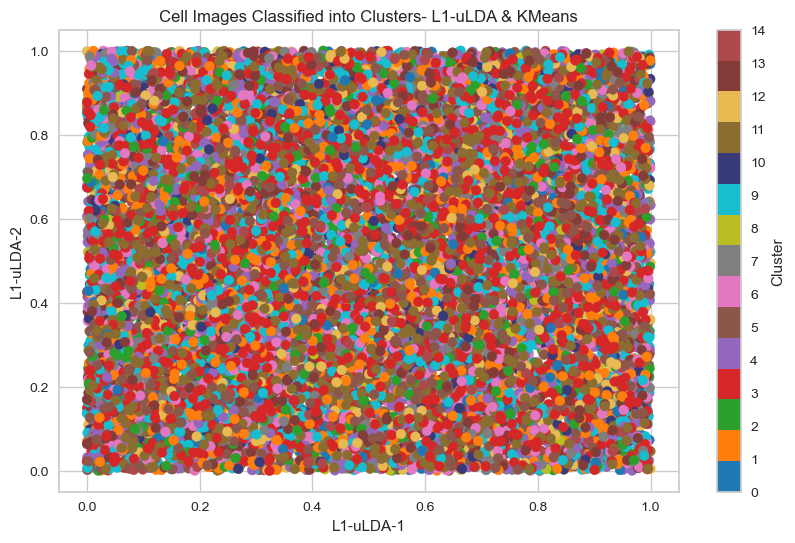

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


data= pd.read_csv("/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output_L1LDA_Kmeans.csv")
# Define a set of more contrasting and visually distinct colors
contrasting_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#8c6d31', '#e7ba52', '#843c39', '#ad494a'
]

# Create a colormap from the list of contrasting colors
custom_cmap_contrasting = mcolors.ListedColormap(contrasting_colors[:15])

# Plotting point_x and point_y with clusters in different colors using the custom colormap
plt.figure(figsize=(10, 6))

# Using a scatter plot to visualize the clusters
scatter = plt.scatter(data['point_x'], data['point_y'], c=data['cluster'], cmap=custom_cmap_contrasting)

# Adding a color bar to indicate the cluster colors
cbar = plt.colorbar(scatter, label='Cluster', ticks=range(15))
cbar.set_ticklabels(range(15))

# Adding titles and labels
plt.title('Cell Images Classified into Clusters- L1-uLDA & KMeans')
plt.xlabel('L1-uLDA-1')
plt.ylabel('L1-uLDA-2')

# Display the plot
plt.show()


In [22]:
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Load the CSV file
file_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output_L1LDA_Kmeans.csv'
data = pd.read_csv(file_path)

# Extracting the relevant data for clustering validation
vectors = data[['point_x', 'point_y']].values
labels = data['cluster'].values

# Calculate the validation metrics
silhouette_avg = silhouette_score(vectors, labels)
calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
davies_bouldin_avg = davies_bouldin_score(vectors, labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")


Silhouette Score: -0.021086111486224475
Calinski-Harabasz Index: 0.7844562257414681
Davies-Bouldin Index: 230.09593276980453


L1-uLDA doesnt provide good results hence planning to drop this approach.

# Using ISOMAP and Kmeans Clustering

In [25]:
import pickle
from argparse import ArgumentParser
from pathlib import Path
from typing import List, Tuple
import time

import numpy as np
from loguru import logger
from tqdm import tqdm
from sklearn.manifold import Isomap

# Function to apply ISOMAP transformation
def apply_isomap(vectors: np.ndarray, n_neighbors: int = 15, n_components: int = 2) -> np.ndarray:
    logger.info(f"Applying ISOMAP with {n_neighbors} neighbors and {n_components} components")
    start_time = time.time()
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    result = isomap.fit_transform(vectors)
    end_time = time.time()
    time_taken = end_time - start_time
    logger.info(f"ISOMAP took {time_taken:.2f} seconds")
    return result

def load_embeddings(file: Path) -> Tuple[List[Path], np.ndarray]:
    embeddings = pickle.loads(file.read_bytes())
    files, vectors = zip(*list(embeddings.items()))
    vectors = np.array(vectors)  # Convert the list of vectors to a numpy array
    return files, vectors

def reduce_dimensionality(embeddings_file: Path, output_file: Path, n_neighbors: int = 15, n_components: int = 2):
    files, vectors = load_embeddings(file=embeddings_file)
    points = apply_isomap(vectors=vectors, n_neighbors=n_neighbors, n_components=n_components)
    points_mapping = dict(zip(files, points))
    output_file.write_bytes(pickle.dumps(points_mapping))

def set_paths_and_run(embeddings_file: str, output_file: str, n_neighbors: int = 15, n_components: int = 2):
    reduce_dimensionality(
        embeddings_file=Path(embeddings_file),
        output_file=Path(output_file),
        n_neighbors=n_neighbors,
        n_components=n_components
    )

if __name__ == "__main__":
    # Example programmatic usage
    embeddings_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/embeddings_aug_B1_primary.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_isomap.pkl"

    set_paths_and_run(embeddings_file, output_file)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('embeddings_file', type=Path)
    # parser.add_argument('--output-file', type=Path, required=True)
    # parser.add_argument('--n_neighbors', type=int, default=5, help='Number of neighbors to consider for each point')
    # parser.add_argument('--n_components', type=int, default=2, help='Number of dimensions to reduce to')
    # args = parser.parse_args()
    # reduce_dimensionality(
    #     embeddings_file=args.embeddings_file,
    #     output_file=args.output_file,
    #     n_neighbors=args.n_neighbors,
    #     n_components=args.n_components)


2024-07-01 17:41:28.522 | INFO     | __main__:apply_isomap:14 - Applying ISOMAP with 15 neighbors and 2 components
2024-07-01 17:44:30.709 | INFO     | __main__:apply_isomap:20 - ISOMAP took 182.19 seconds


In [26]:
import pickle
from argparse import ArgumentParser
from collections import defaultdict
from pathlib import Path
from typing import List, Tuple

import pandas as pd

def load_file_contents(file: Path) -> Tuple[List[Path], List]:
    return pickle.loads(file.read_bytes())

def export_csv(clusters_file: Path, points_file: Path, output_file: Path):
    clusters_data = load_file_contents(clusters_file)
    points_data = load_file_contents(points_file)

    data = defaultdict(dict)
    for key, cluster in clusters_data.items():
        data[key]["cluster"] = cluster
        point = points_data[key]
        data[key]["point_x"], data[key]["point_y"] = point

    df: pd.DataFrame = pd.DataFrame.from_dict(data, orient="index") \
        .rename_axis('cell_location') \
        .reset_index() \
        .assign(cell_location=lambda df: df.cell_location.apply(Path)) \
        .assign(parent_image=lambda df: df.cell_location.apply(lambda path: path.parent.name))

    df.to_csv(output_file, index=False)

def set_paths_and_run(clusters_file: str, points_file: str, output_file: str):
    export_csv(
        clusters_file=Path(clusters_file),
        points_file=Path(points_file),
        output_file=Path(output_file)
    )

if __name__ == "__main__":
    # Example programmatic usage
    clusters_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/clusters.pkl"
    points_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_isomap.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output_isomap_Kmeans.csv"

    set_paths_and_run(clusters_file, points_file, output_file)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('--clusters', type=Path, required=True)
    # parser.add_argument('--points', type=Path, required=True)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # export_csv(
    #     clusters_file=args.clusters,
    #     points_file=args.points,
    #     output_file=args.output_file)


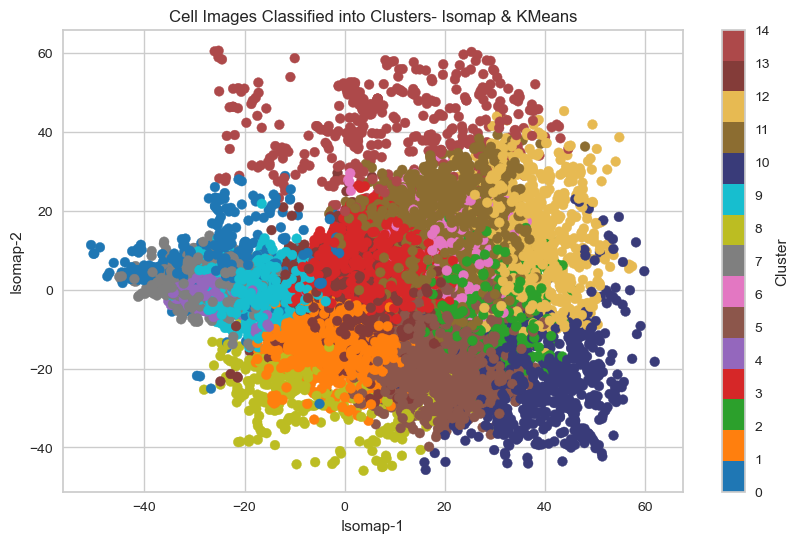

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


data= pd.read_csv("/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output_isomap_Kmeans.csv")
# Define a set of more contrasting and visually distinct colors
contrasting_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#8c6d31', '#e7ba52', '#843c39', '#ad494a'
]

# Create a colormap from the list of contrasting colors
custom_cmap_contrasting = mcolors.ListedColormap(contrasting_colors[:15])

# Plotting point_x and point_y with clusters in different colors using the custom colormap
plt.figure(figsize=(10, 6))

# Using a scatter plot to visualize the clusters
scatter = plt.scatter(data['point_x'], data['point_y'], c=data['cluster'], cmap=custom_cmap_contrasting)

# Adding a color bar to indicate the cluster colors
cbar = plt.colorbar(scatter, label='Cluster', ticks=range(15))
cbar.set_ticklabels(range(15))

# Adding titles and labels
plt.title('Cell Images Classified into Clusters- Isomap & KMeans')
plt.xlabel('Isomap-1')
plt.ylabel('Isomap-2')

# Display the plot
plt.show()


In [29]:
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Load the CSV file
file_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/output_isomap_Kmeans.csv'
data = pd.read_csv(file_path)

# Extracting the relevant data for clustering validation
vectors = data[['point_x', 'point_y']].values
labels = data['cluster'].values

# Calculate the validation metrics
silhouette_avg = silhouette_score(vectors, labels)
calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
davies_bouldin_avg = davies_bouldin_score(vectors, labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")


Silhouette Score: 0.03576198541255407
Calinski-Harabasz Index: 7000.453607915546
Davies-Bouldin Index: 2.3620086309890755


# Using reduced points for both clustering and Visualisation- Approach 2

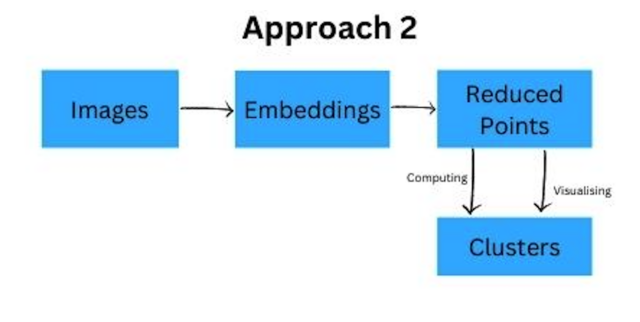

In [73]:
from PIL import Image
import matplotlib.pyplot as plt

# Open an image file
image_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/Screenshot 2024-07-03 at 11.13.28 am.png'
img = Image.open(image_path)

# Display the image in the notebook
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()


# UMAP & Kmeans

In [51]:
import pickle
import time
from argparse import ArgumentParser
from pathlib import Path
from typing import List, Optional, Tuple

import numpy as np
from loguru import logger
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
from kneed import KneeLocator

def load_embeddings(file: Path) -> Tuple[List[Path], np.ndarray]:
    start_time = time.time()
    embeddings = pickle.loads(file.read_bytes())
    files, vectors = zip(*list(embeddings.items()))
    vectors = np.array(vectors)  # Ensure vectors are a NumPy array
    end_time = time.time()
    logger.info(f"Time taken to load embeddings: {end_time - start_time:.2f} seconds")
    return files, vectors


def make_clusters(vectors: np.ndarray, n_clusters: int) -> np.ndarray:
    start_time = time.time()
    kMeans = KMeans(n_clusters=n_clusters, random_state=42)
    logger.info(f"Clustering with {kMeans}")
    labels = kMeans.fit_predict(vectors)
    end_time = time.time()
    logger.info(f"Time taken for clustering: {end_time - start_time:.2f} seconds")
    return labels


def find_optimal_number_of_clusters(values: List[int], data: np.ndarray) -> int:
    start_time = time.time()
    logger.info("Finding optimal value for k ...")
    inertias = [KMeans(n_clusters=n, random_state=42).fit(data).inertia_ for n in tqdm(values)]
    kneedle = KneeLocator(x=values, y=inertias, direction='decreasing', curve='convex')
    end_time = time.time()
    logger.info(inertias)
    logger.info(f"Optimal k={kneedle.elbow}")
    logger.info(f"Time taken to find optimal number of clusters: {end_time - start_time:.2f} seconds")
    return kneedle.elbow


def validate_clusters(vectors: np.ndarray, labels: np.ndarray):
    start_time = time.time()
    silhouette_avg = silhouette_score(vectors, labels)
    calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
    davies_bouldin_avg = davies_bouldin_score(vectors, labels)
    end_time = time.time()
    logger.info(f"Silhouette Score: {silhouette_avg}")
    logger.info(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
    logger.info(f"Davies-Bouldin Index: {davies_bouldin_avg}")
    logger.info(f"Time taken for validation: {end_time - start_time:.2f} seconds")
    return silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg


def compute_clusters(embeddings_file: Path, output_file: Path, clusters: Optional[int] = None):
    files, vectors = load_embeddings(file=embeddings_file)
    if clusters is None:
        clusters = find_optimal_number_of_clusters(range(5, 45, 5), data=vectors)
    labels = make_clusters(vectors=vectors, n_clusters=clusters)
    validate_clusters(vectors=vectors, labels=labels)  # Add validation step
    cluster_mapping = dict(zip(files, labels))
    output_file.write_bytes(pickle.dumps(cluster_mapping))


def set_paths_and_run(embeddings_file: str, output_file: str, clusters: Optional[int] = None):
    compute_clusters(
        embeddings_file=Path(embeddings_file),
        output_file=Path(output_file),
        clusters=clusters
    )


if __name__ == "__main__":
    # Example programmatic usage
    embeddings_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_UMAP.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/rclusters_UMAP_Kmeans.pkl"
    clusters = None  # Or specify an integer for a fixed number of clusters

    set_paths_and_run(embeddings_file, output_file, clusters)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('embeddings_file', type=Path)
    # parser.add_argument('--clusters', type=lambda x: int(x) if x else None, default=None, required=False)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # compute_clusters(
    #     embeddings_file=args.embeddings_file,
    #     output_file=args.output_file,
    #     clusters=args.clusters)


2024-07-02 17:07:10.787 | INFO     | __main__:load_embeddings:20 - Time taken to load embeddings: 0.03 seconds
2024-07-02 17:07:10.789 | INFO     | __main__:find_optimal_number_of_clusters:36 - Finding optimal value for k ...
100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 32.86it/s]
2024-07-02 17:07:11.034 | INFO     | __main__:find_optimal_number_of_clusters:40 - [85541.3046875, 37766.609375, 24339.61328125, 17761.05078125, 13843.109375, 11472.673828125, 9490.1328125, 8324.1533203125]
2024-07-02 17:07:11.035 | INFO     | __main__:find_optimal_number_of_clusters:41 - Optimal k=15
2024-07-02 17:07:11.035 | INFO     | __main__:find_optimal_number_of_clusters:42 - Time taken to find optimal number of clusters: 0.25 seconds
2024-07-02 17:07:11.035 | INFO     | __main__:make_clusters:27 - Clustering with KMeans(n_clusters=15, random_state=42)
2024-07-02 17:07:11.054 | INFO     | __main__:make_clusters:30 - Time taken for clustering: 0.02 seconds
2024-07-02 17:07:14.85

In [54]:
import pickle
from argparse import ArgumentParser
from collections import defaultdict
from pathlib import Path
from typing import List, Tuple

import pandas as pd

def load_file_contents(file: Path) -> Tuple[List[Path], List]:
    return pickle.loads(file.read_bytes())

def export_csv(clusters_file: Path, points_file: Path, output_file: Path):
    clusters_data = load_file_contents(clusters_file)
    points_data = load_file_contents(points_file)

    data = defaultdict(dict)
    for key, cluster in clusters_data.items():
        data[key]["cluster"] = cluster
        point = points_data[key]
        data[key]["point_x"], data[key]["point_y"] = point

    df: pd.DataFrame = pd.DataFrame.from_dict(data, orient="index") \
        .rename_axis('cell_location') \
        .reset_index() \
        .assign(cell_location=lambda df: df.cell_location.apply(Path)) \
        .assign(parent_image=lambda df: df.cell_location.apply(lambda path: path.parent.name))

    df.to_csv(output_file, index=False)

def set_paths_and_run(clusters_file: str, points_file: str, output_file: str):
    export_csv(
        clusters_file=Path(clusters_file),
        points_file=Path(points_file),
        output_file=Path(output_file)
    )

if __name__ == "__main__":
    # Example programmatic usage
    clusters_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/rclusters_UMAP_Kmeans.pkl"
    points_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_UMAP.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_UMAP_Kmeans.csv"

    set_paths_and_run(clusters_file, points_file, output_file)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('--clusters', type=Path, required=True)
    # parser.add_argument('--points', type=Path, required=True)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # export_csv(
    #     clusters_file=args.clusters,
    #     points_file=args.points,
    #     output_file=args.output_file)


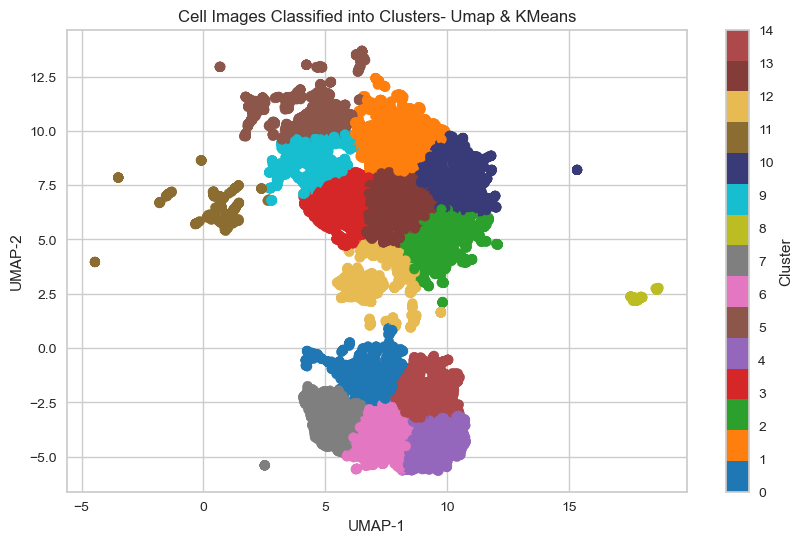

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


data= pd.read_csv("/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_UMAP_Kmeans.csv")
# Define a set of more contrasting and visually distinct colors
contrasting_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#8c6d31', '#e7ba52', '#843c39', '#ad494a'
]

# Create a colormap from the list of contrasting colors
custom_cmap_contrasting = mcolors.ListedColormap(contrasting_colors[:15])

# Plotting point_x and point_y with clusters in different colors using the custom colormap
plt.figure(figsize=(10, 6))

# Using a scatter plot to visualize the clusters
scatter = plt.scatter(data['point_x'], data['point_y'], c=data['cluster'], cmap=custom_cmap_contrasting)

# Adding a color bar to indicate the cluster colors
cbar = plt.colorbar(scatter, label='Cluster', ticks=range(15))
cbar.set_ticklabels(range(15))

# Adding titles and labels
plt.title('Cell Images Classified into Clusters- Umap & KMeans')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

# Display the plot
plt.show()


In [56]:
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Load the CSV file
file_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_UMAP_Kmeans.csv'
data = pd.read_csv(file_path)

# Extracting the relevant data for clustering validation
vectors = data[['point_x', 'point_y']].values
labels = data['cluster'].values

# Calculate the validation metrics
silhouette_avg = silhouette_score(vectors, labels)
calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
davies_bouldin_avg = davies_bouldin_score(vectors, labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")


Silhouette Score: 0.3769050864318288
Calinski-Harabasz Index: 32755.28657501921
Davies-Bouldin Index: 0.7695051926830127


Metrics provide better accuracy and clustering than default approach in PhiDDLi

# Tsne and Kmeans Clustering

In [50]:
import pickle
import time
from argparse import ArgumentParser
from pathlib import Path
from typing import List, Optional, Tuple

import numpy as np
from loguru import logger
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
from kneed import KneeLocator

def load_embeddings(file: Path) -> Tuple[List[Path], np.ndarray]:
    start_time = time.time()
    embeddings = pickle.loads(file.read_bytes())
    files, vectors = zip(*list(embeddings.items()))
    vectors = np.array(vectors)  # Ensure vectors are a NumPy array
    end_time = time.time()
    logger.info(f"Time taken to load embeddings: {end_time - start_time:.2f} seconds")
    return files, vectors


def make_clusters(vectors: np.ndarray, n_clusters: int) -> np.ndarray:
    start_time = time.time()
    kMeans = KMeans(n_clusters=n_clusters, random_state=42)
    logger.info(f"Clustering with {kMeans}")
    labels = kMeans.fit_predict(vectors)
    end_time = time.time()
    logger.info(f"Time taken for clustering: {end_time - start_time:.2f} seconds")
    return labels


def find_optimal_number_of_clusters(values: List[int], data: np.ndarray) -> int:
    start_time = time.time()
    logger.info("Finding optimal value for k ...")
    inertias = [KMeans(n_clusters=n, random_state=42).fit(data).inertia_ for n in tqdm(values)]
    kneedle = KneeLocator(x=values, y=inertias, direction='decreasing', curve='convex')
    end_time = time.time()
    logger.info(inertias)
    logger.info(f"Optimal k={kneedle.elbow}")
    logger.info(f"Time taken to find optimal number of clusters: {end_time - start_time:.2f} seconds")
    return kneedle.elbow


def validate_clusters(vectors: np.ndarray, labels: np.ndarray):
    start_time = time.time()
    silhouette_avg = silhouette_score(vectors, labels)
    calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
    davies_bouldin_avg = davies_bouldin_score(vectors, labels)
    end_time = time.time()
    logger.info(f"Silhouette Score: {silhouette_avg}")
    logger.info(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
    logger.info(f"Davies-Bouldin Index: {davies_bouldin_avg}")
    logger.info(f"Time taken for validation: {end_time - start_time:.2f} seconds")
    return silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg


def compute_clusters(embeddings_file: Path, output_file: Path, clusters: Optional[int] = None):
    files, vectors = load_embeddings(file=embeddings_file)
    if clusters is None:
        clusters = find_optimal_number_of_clusters(range(5, 45, 5), data=vectors)
    labels = make_clusters(vectors=vectors, n_clusters=clusters)
    validate_clusters(vectors=vectors, labels=labels)  # Add validation step
    cluster_mapping = dict(zip(files, labels))
    output_file.write_bytes(pickle.dumps(cluster_mapping))


def set_paths_and_run(embeddings_file: str, output_file: str, clusters: Optional[int] = None):
    compute_clusters(
        embeddings_file=Path(embeddings_file),
        output_file=Path(output_file),
        clusters=clusters
    )


if __name__ == "__main__":
    # Example programmatic usage
    embeddings_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_embeddings_aug_B1_primary.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_tsne_clusters_Kmeans.pkl"
    clusters = None  # Or specify an integer for a fixed number of clusters

    set_paths_and_run(embeddings_file, output_file, clusters)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('embeddings_file', type=Path)
    # parser.add_argument('--clusters', type=lambda x: int(x) if x else None, default=None, required=False)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # compute_clusters(
    #     embeddings_file=args.embeddings_file,
    #     output_file=args.output_file,
    #     clusters=args.clusters)


2024-07-02 17:05:54.945 | INFO     | __main__:load_embeddings:20 - Time taken to load embeddings: 0.02 seconds
2024-07-02 17:05:54.948 | INFO     | __main__:find_optimal_number_of_clusters:36 - Finding optimal value for k ...
100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 26.00it/s]
2024-07-02 17:05:55.257 | INFO     | __main__:find_optimal_number_of_clusters:40 - [19678112.0, 10536811.0, 6670655.5, 4870804.0, 3948159.5, 3222685.75, 2745276.75, 2433224.75]
2024-07-02 17:05:55.257 | INFO     | __main__:find_optimal_number_of_clusters:41 - Optimal k=15
2024-07-02 17:05:55.258 | INFO     | __main__:find_optimal_number_of_clusters:42 - Time taken to find optimal number of clusters: 0.31 seconds
2024-07-02 17:05:55.259 | INFO     | __main__:make_clusters:27 - Clustering with KMeans(n_clusters=15, random_state=42)
2024-07-02 17:05:55.286 | INFO     | __main__:make_clusters:30 - Time taken for clustering: 0.03 seconds
2024-07-02 17:06:00.276 | INFO     | __main__:valida

In [57]:
import pickle
from argparse import ArgumentParser
from collections import defaultdict
from pathlib import Path
from typing import List, Tuple

import pandas as pd

def load_file_contents(file: Path) -> Tuple[List[Path], List]:
    return pickle.loads(file.read_bytes())

def export_csv(clusters_file: Path, points_file: Path, output_file: Path):
    clusters_data = load_file_contents(clusters_file)
    points_data = load_file_contents(points_file)

    data = defaultdict(dict)
    for key, cluster in clusters_data.items():
        data[key]["cluster"] = cluster
        point = points_data[key]
        data[key]["point_x"], data[key]["point_y"] = point

    df: pd.DataFrame = pd.DataFrame.from_dict(data, orient="index") \
        .rename_axis('cell_location') \
        .reset_index() \
        .assign(cell_location=lambda df: df.cell_location.apply(Path)) \
        .assign(parent_image=lambda df: df.cell_location.apply(lambda path: path.parent.name))

    df.to_csv(output_file, index=False)

def set_paths_and_run(clusters_file: str, points_file: str, output_file: str):
    export_csv(
        clusters_file=Path(clusters_file),
        points_file=Path(points_file),
        output_file=Path(output_file)
    )

if __name__ == "__main__":
    # Example programmatic usage
    clusters_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_tsne_clusters_Kmeans.pkl"
    points_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_embeddings_aug_B1_primary.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_tsne_Kmeans.csv"

    set_paths_and_run(clusters_file, points_file, output_file)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('--clusters', type=Path, required=True)
    # parser.add_argument('--points', type=Path, required=True)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # export_csv(
    #     clusters_file=args.clusters,
    #     points_file=args.points,
    #     output_file=args.output_file)


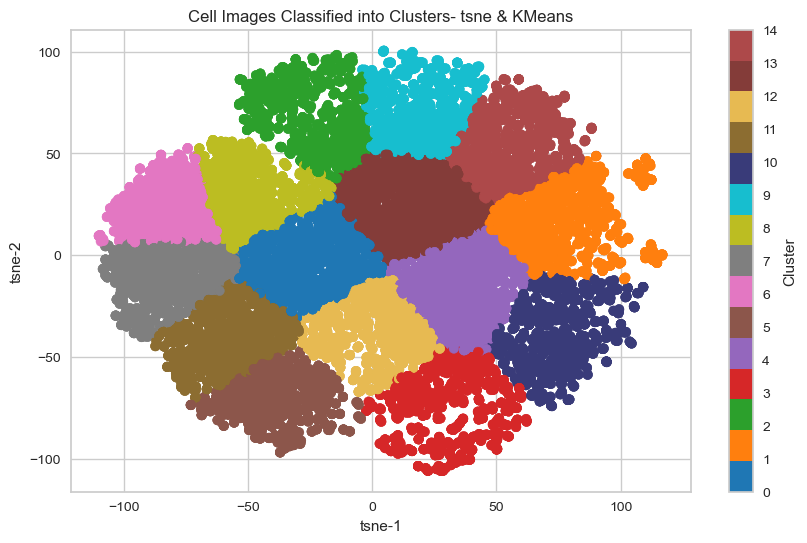

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


data= pd.read_csv("/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_tsne_Kmeans.csv")
# Define a set of more contrasting and visually distinct colors
contrasting_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#8c6d31', '#e7ba52', '#843c39', '#ad494a'
]

# Create a colormap from the list of contrasting colors
custom_cmap_contrasting = mcolors.ListedColormap(contrasting_colors[:15])

# Plotting point_x and point_y with clusters in different colors using the custom colormap
plt.figure(figsize=(10, 6))

# Using a scatter plot to visualize the clusters
scatter = plt.scatter(data['point_x'], data['point_y'], c=data['cluster'], cmap=custom_cmap_contrasting)

# Adding a color bar to indicate the cluster colors
cbar = plt.colorbar(scatter, label='Cluster', ticks=range(15))
cbar.set_ticklabels(range(15))

# Adding titles and labels
plt.title('Cell Images Classified into Clusters- tsne & KMeans')
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')

# Display the plot
plt.show()


In [59]:
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Load the CSV file
file_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_tsne_Kmeans.csv'
data = pd.read_csv(file_path)

# Extracting the relevant data for clustering validation
vectors = data[['point_x', 'point_y']].values
labels = data['cluster'].values

# Calculate the validation metrics
silhouette_avg = silhouette_score(vectors, labels)
calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
davies_bouldin_avg = davies_bouldin_score(vectors, labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")


Silhouette Score: 0.3321931241769189
Calinski-Harabasz Index: 15956.86610953203
Davies-Bouldin Index: 0.8601461693288908


# KPCA and K means Clustering

In [60]:
import pickle
import time
from argparse import ArgumentParser
from pathlib import Path
from typing import List, Optional, Tuple

import numpy as np
from loguru import logger
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
from kneed import KneeLocator

def load_embeddings(file: Path) -> Tuple[List[Path], np.ndarray]:
    start_time = time.time()
    embeddings = pickle.loads(file.read_bytes())
    files, vectors = zip(*list(embeddings.items()))
    vectors = np.array(vectors)  # Ensure vectors are a NumPy array
    end_time = time.time()
    logger.info(f"Time taken to load embeddings: {end_time - start_time:.2f} seconds")
    return files, vectors


def make_clusters(vectors: np.ndarray, n_clusters: int) -> np.ndarray:
    start_time = time.time()
    kMeans = KMeans(n_clusters=n_clusters, random_state=42)
    logger.info(f"Clustering with {kMeans}")
    labels = kMeans.fit_predict(vectors)
    end_time = time.time()
    logger.info(f"Time taken for clustering: {end_time - start_time:.2f} seconds")
    return labels


def find_optimal_number_of_clusters(values: List[int], data: np.ndarray) -> int:
    start_time = time.time()
    logger.info("Finding optimal value for k ...")
    inertias = [KMeans(n_clusters=n, random_state=42).fit(data).inertia_ for n in tqdm(values)]
    kneedle = KneeLocator(x=values, y=inertias, direction='decreasing', curve='convex')
    end_time = time.time()
    logger.info(inertias)
    logger.info(f"Optimal k={kneedle.elbow}")
    logger.info(f"Time taken to find optimal number of clusters: {end_time - start_time:.2f} seconds")
    return kneedle.elbow


def validate_clusters(vectors: np.ndarray, labels: np.ndarray):
    start_time = time.time()
    silhouette_avg = silhouette_score(vectors, labels)
    calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
    davies_bouldin_avg = davies_bouldin_score(vectors, labels)
    end_time = time.time()
    logger.info(f"Silhouette Score: {silhouette_avg}")
    logger.info(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
    logger.info(f"Davies-Bouldin Index: {davies_bouldin_avg}")
    logger.info(f"Time taken for validation: {end_time - start_time:.2f} seconds")
    return silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg


def compute_clusters(embeddings_file: Path, output_file: Path, clusters: Optional[int] = None):
    files, vectors = load_embeddings(file=embeddings_file)
    if clusters is None:
        clusters = find_optimal_number_of_clusters(range(5, 45, 5), data=vectors)
    labels = make_clusters(vectors=vectors, n_clusters=clusters)
    validate_clusters(vectors=vectors, labels=labels)  # Add validation step
    cluster_mapping = dict(zip(files, labels))
    output_file.write_bytes(pickle.dumps(cluster_mapping))


def set_paths_and_run(embeddings_file: str, output_file: str, clusters: Optional[int] = None):
    compute_clusters(
        embeddings_file=Path(embeddings_file),
        output_file=Path(output_file),
        clusters=clusters
    )


if __name__ == "__main__":
    # Example programmatic usage
    embeddings_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_kernel_PCA.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_KPCA_clusters_Kmeans.pkl"
    clusters = None  # Or specify an integer for a fixed number of clusters

    set_paths_and_run(embeddings_file, output_file, clusters)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('embeddings_file', type=Path)
    # parser.add_argument('--clusters', type=lambda x: int(x) if x else None, default=None, required=False)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # compute_clusters(
    #     embeddings_file=args.embeddings_file,
    #     output_file=args.output_file,
    #     clusters=args.clusters)


2024-07-02 19:32:58.029 | INFO     | __main__:load_embeddings:20 - Time taken to load embeddings: 0.09 seconds
2024-07-02 19:32:58.032 | INFO     | __main__:find_optimal_number_of_clusters:36 - Finding optimal value for k ...
100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.01it/s]
2024-07-02 19:32:58.936 | INFO     | __main__:find_optimal_number_of_clusters:40 - [246.52494581459916, 126.85811056978335, 82.40401945462045, 62.98255211838109, 50.69273727278992, 42.038021296197414, 36.2471285546609, 31.164237147224174]
2024-07-02 19:32:58.946 | INFO     | __main__:find_optimal_number_of_clusters:41 - Optimal k=15
2024-07-02 19:32:58.948 | INFO     | __main__:find_optimal_number_of_clusters:42 - Time taken to find optimal number of clusters: 0.90 seconds
2024-07-02 19:32:58.949 | INFO     | __main__:make_clusters:27 - Clustering with KMeans(n_clusters=15, random_state=42)
2024-07-02 19:32:59.037 | INFO     | __main__:make_clusters:30 - Time taken for clustering: 0.0

In [61]:
import pickle
from argparse import ArgumentParser
from collections import defaultdict
from pathlib import Path
from typing import List, Tuple

import pandas as pd

def load_file_contents(file: Path) -> Tuple[List[Path], List]:
    return pickle.loads(file.read_bytes())

def export_csv(clusters_file: Path, points_file: Path, output_file: Path):
    clusters_data = load_file_contents(clusters_file)
    points_data = load_file_contents(points_file)

    data = defaultdict(dict)
    for key, cluster in clusters_data.items():
        data[key]["cluster"] = cluster
        point = points_data[key]
        data[key]["point_x"], data[key]["point_y"] = point

    df: pd.DataFrame = pd.DataFrame.from_dict(data, orient="index") \
        .rename_axis('cell_location') \
        .reset_index() \
        .assign(cell_location=lambda df: df.cell_location.apply(Path)) \
        .assign(parent_image=lambda df: df.cell_location.apply(lambda path: path.parent.name))

    df.to_csv(output_file, index=False)

def set_paths_and_run(clusters_file: str, points_file: str, output_file: str):
    export_csv(
        clusters_file=Path(clusters_file),
        points_file=Path(points_file),
        output_file=Path(output_file)
    )

if __name__ == "__main__":
    # Example programmatic usage
    clusters_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_KPCA_clusters_Kmeans.pkl"
    points_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_kernel_PCA.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_KPCA_Kmeans.csv"

    set_paths_and_run(clusters_file, points_file, output_file)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('--clusters', type=Path, required=True)
    # parser.add_argument('--points', type=Path, required=True)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # export_csv(
    #     clusters_file=args.clusters,
    #     points_file=args.points,
    #     output_file=args.output_file)


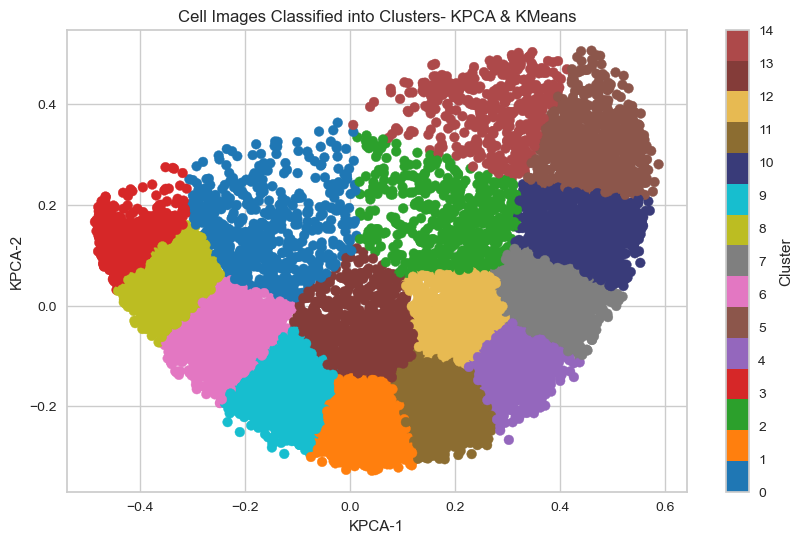

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


data= pd.read_csv("/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_KPCA_Kmeans.csv")
# Define a set of more contrasting and visually distinct colors
contrasting_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#8c6d31', '#e7ba52', '#843c39', '#ad494a'
]

# Create a colormap from the list of contrasting colors
custom_cmap_contrasting = mcolors.ListedColormap(contrasting_colors[:15])

# Plotting point_x and point_y with clusters in different colors using the custom colormap
plt.figure(figsize=(10, 6))

# Using a scatter plot to visualize the clusters
scatter = plt.scatter(data['point_x'], data['point_y'], c=data['cluster'], cmap=custom_cmap_contrasting)

# Adding a color bar to indicate the cluster colors
cbar = plt.colorbar(scatter, label='Cluster', ticks=range(15))
cbar.set_ticklabels(range(15))

# Adding titles and labels
plt.title('Cell Images Classified into Clusters- KPCA & KMeans')
plt.xlabel('KPCA-1')
plt.ylabel('KPCA-2')

# Display the plot
plt.show()


In [63]:
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Load the CSV file
file_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_KPCA_Kmeans.csv'
data = pd.read_csv(file_path)

# Extracting the relevant data for clustering validation
vectors = data[['point_x', 'point_y']].values
labels = data['cluster'].values

# Calculate the validation metrics
silhouette_avg = silhouette_score(vectors, labels)
calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
davies_bouldin_avg = davies_bouldin_score(vectors, labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")


Silhouette Score: 0.36355959237107605
Calinski-Harabasz Index: 32825.04858449187
Davies-Bouldin Index: 0.8195886208191094


# ISOMAP and Kmeans Clustering

In [66]:
import pickle
import time
from argparse import ArgumentParser
from pathlib import Path
from typing import List, Optional, Tuple

import numpy as np
from loguru import logger
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
from kneed import KneeLocator

def load_embeddings(file: Path) -> Tuple[List[Path], np.ndarray]:
    start_time = time.time()
    embeddings = pickle.loads(file.read_bytes())
    files, vectors = zip(*list(embeddings.items()))
    vectors = np.array(vectors)  # Ensure vectors are a NumPy array
    end_time = time.time()
    logger.info(f"Time taken to load embeddings: {end_time - start_time:.2f} seconds")
    return files, vectors


def make_clusters(vectors: np.ndarray, n_clusters: int) -> np.ndarray:
    start_time = time.time()
    kMeans = KMeans(n_clusters=n_clusters, random_state=42)
    logger.info(f"Clustering with {kMeans}")
    labels = kMeans.fit_predict(vectors)
    end_time = time.time()
    logger.info(f"Time taken for clustering: {end_time - start_time:.2f} seconds")
    return labels


def find_optimal_number_of_clusters(values: List[int], data: np.ndarray) -> int:
    start_time = time.time()
    logger.info("Finding optimal value for k ...")
    inertias = [KMeans(n_clusters=n, random_state=42).fit(data).inertia_ for n in tqdm(values)]
    kneedle = KneeLocator(x=values, y=inertias, direction='decreasing', curve='convex')
    end_time = time.time()
    logger.info(inertias)
    logger.info(f"Optimal k={kneedle.elbow}")
    logger.info(f"Time taken to find optimal number of clusters: {end_time - start_time:.2f} seconds")
    return kneedle.elbow


def validate_clusters(vectors: np.ndarray, labels: np.ndarray):
    start_time = time.time()
    silhouette_avg = silhouette_score(vectors, labels)
    calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
    davies_bouldin_avg = davies_bouldin_score(vectors, labels)
    end_time = time.time()
    logger.info(f"Silhouette Score: {silhouette_avg}")
    logger.info(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
    logger.info(f"Davies-Bouldin Index: {davies_bouldin_avg}")
    logger.info(f"Time taken for validation: {end_time - start_time:.2f} seconds")
    return silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg


def compute_clusters(embeddings_file: Path, output_file: Path, clusters: Optional[int] = None):
    files, vectors = load_embeddings(file=embeddings_file)
    if clusters is None:
        clusters = find_optimal_number_of_clusters(range(5, 45, 5), data=vectors)
    labels = make_clusters(vectors=vectors, n_clusters=clusters)
    validate_clusters(vectors=vectors, labels=labels)  # Add validation step
    cluster_mapping = dict(zip(files, labels))
    output_file.write_bytes(pickle.dumps(cluster_mapping))


def set_paths_and_run(embeddings_file: str, output_file: str, clusters: Optional[int] = None):
    compute_clusters(
        embeddings_file=Path(embeddings_file),
        output_file=Path(output_file),
        clusters=clusters
    )


if __name__ == "__main__":
    # Example programmatic usage
    embeddings_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_isomap.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_isomap_clusters_Kmeans.pkl"
    clusters = None  # Or specify an integer for a fixed number of clusters

    set_paths_and_run(embeddings_file, output_file, clusters)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('embeddings_file', type=Path)
    # parser.add_argument('--clusters', type=lambda x: int(x) if x else None, default=None, required=False)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # compute_clusters(
    #     embeddings_file=args.embeddings_file,
    #     output_file=args.output_file,
    #     clusters=args.clusters)


2024-07-02 20:25:59.479 | INFO     | __main__:load_embeddings:20 - Time taken to load embeddings: 0.03 seconds
2024-07-02 20:25:59.482 | INFO     | __main__:find_optimal_number_of_clusters:36 - Finding optimal value for k ...
100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  6.47it/s]
2024-07-02 20:26:00.727 | INFO     | __main__:find_optimal_number_of_clusters:40 - [2218347.9497547955, 1215296.0640810868, 827372.200196492, 642207.0249273432, 517459.4706186442, 440661.7424696122, 373620.7498709692, 328281.6333109898]
2024-07-02 20:26:00.734 | INFO     | __main__:find_optimal_number_of_clusters:41 - Optimal k=15
2024-07-02 20:26:00.737 | INFO     | __main__:find_optimal_number_of_clusters:42 - Time taken to find optimal number of clusters: 1.24 seconds
2024-07-02 20:26:00.756 | INFO     | __main__:make_clusters:27 - Clustering with KMeans(n_clusters=15, random_state=42)
2024-07-02 20:26:01.033 | INFO     | __main__:make_clusters:30 - Time taken for clustering: 0.28 

In [67]:
import pickle
from argparse import ArgumentParser
from collections import defaultdict
from pathlib import Path
from typing import List, Tuple

import pandas as pd

def load_file_contents(file: Path) -> Tuple[List[Path], List]:
    return pickle.loads(file.read_bytes())

def export_csv(clusters_file: Path, points_file: Path, output_file: Path):
    clusters_data = load_file_contents(clusters_file)
    points_data = load_file_contents(points_file)

    data = defaultdict(dict)
    for key, cluster in clusters_data.items():
        data[key]["cluster"] = cluster
        point = points_data[key]
        data[key]["point_x"], data[key]["point_y"] = point

    df: pd.DataFrame = pd.DataFrame.from_dict(data, orient="index") \
        .rename_axis('cell_location') \
        .reset_index() \
        .assign(cell_location=lambda df: df.cell_location.apply(Path)) \
        .assign(parent_image=lambda df: df.cell_location.apply(lambda path: path.parent.name))

    df.to_csv(output_file, index=False)

def set_paths_and_run(clusters_file: str, points_file: str, output_file: str):
    export_csv(
        clusters_file=Path(clusters_file),
        points_file=Path(points_file),
        output_file=Path(output_file)
    )

if __name__ == "__main__":
    # Example programmatic usage
    clusters_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_isomap_clusters_Kmeans.pkl"
    points_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/reduced_isomap.pkl"
    output_file = "/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_isomap_Kmeans.csv"

    set_paths_and_run(clusters_file, points_file, output_file)

    # Uncomment the following lines if you want to use command-line arguments instead
    # parser = ArgumentParser()
    # parser.add_argument('--clusters', type=Path, required=True)
    # parser.add_argument('--points', type=Path, required=True)
    # parser.add_argument('--output-file', type=Path, required=True)
    # args = parser.parse_args()
    # export_csv(
    #     clusters_file=args.clusters,
    #     points_file=args.points,
    #     output_file=args.output_file)


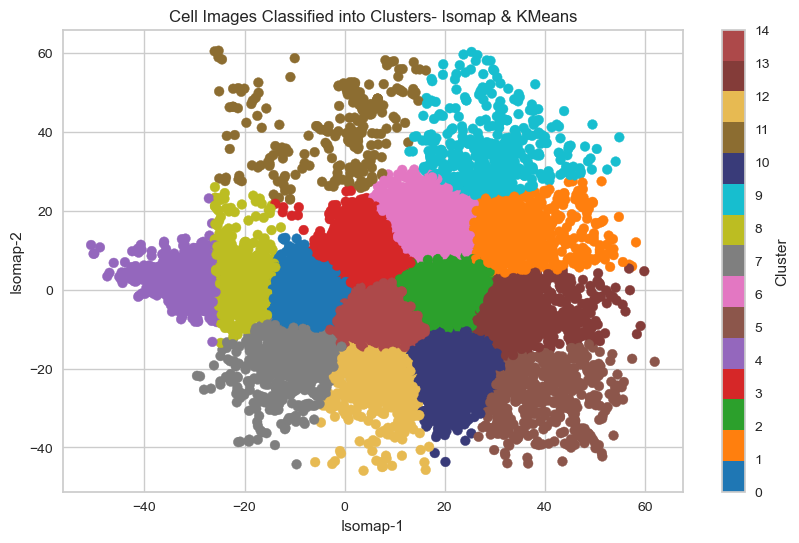

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


data= pd.read_csv("/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_isomap_Kmeans.csv")
# Define a set of more contrasting and visually distinct colors
contrasting_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#8c6d31', '#e7ba52', '#843c39', '#ad494a'
]

# Create a colormap from the list of contrasting colors
custom_cmap_contrasting = mcolors.ListedColormap(contrasting_colors[:15])

# Plotting point_x and point_y with clusters in different colors using the custom colormap
plt.figure(figsize=(10, 6))

# Using a scatter plot to visualize the clusters
scatter = plt.scatter(data['point_x'], data['point_y'], c=data['cluster'], cmap=custom_cmap_contrasting)

# Adding a color bar to indicate the cluster colors
cbar = plt.colorbar(scatter, label='Cluster', ticks=range(15))
cbar.set_ticklabels(range(15))

# Adding titles and labels
plt.title('Cell Images Classified into Clusters- Isomap & KMeans')
plt.xlabel('Isomap-1')
plt.ylabel('Isomap-2')

# Display the plot
plt.show()


In [70]:
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Load the CSV file
file_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_isomap_Kmeans.csv'
data = pd.read_csv(file_path)

# Extracting the relevant data for clustering validation
vectors = data[['point_x', 'point_y']].values
labels = data['cluster'].values

# Calculate the validation metrics
silhouette_avg = silhouette_score(vectors, labels)
calinski_harabasz_avg = calinski_harabasz_score(vectors, labels)
davies_bouldin_avg = davies_bouldin_score(vectors, labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg}")


Silhouette Score: 0.3448670804508948
Calinski-Harabasz Index: 18461.815731801675
Davies-Bouldin Index: 0.8556545128981832
